In [48]:
!pip install -q tensorflow
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load MNIST Dataset

In [51]:
from tensorflow.keras.datasets import mnist
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.0  # Normalize to [-1, 1]
X_train = X_train.reshape(-1, 28*28)

# Display a few sample images

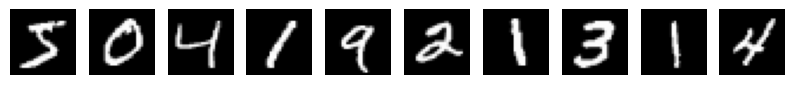

In [52]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


# Generator Model

In [53]:
def build_generator(noise_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=noise_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28)))
    return model

# Discriminator Model

In [55]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile Models

In [62]:
noise_dim = 100
generator = build_generator(noise_dim)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam')  # No metrics

# Combined model (generator + discriminator)
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

# GAN Model

In [63]:
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam())


In [66]:
def train_gan(epochs=1000, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx].reshape(-1, 28, 28)  # ✅ FIX: reshape to (28, 28)

        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 200 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")



# Train Model

In [67]:
train_gan(epochs=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 0 | D Loss: 0.5202 | G Loss: 0.5087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━

# Generate and Plot Images

In [68]:
def generate_images(generator, n=25):
    noise = np.random.normal(0, 1, (n, noise_dim))
    gen_imgs = generator.predict(noise)

    plt.figure(figsize=(5, 5))
    for i in range(n):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


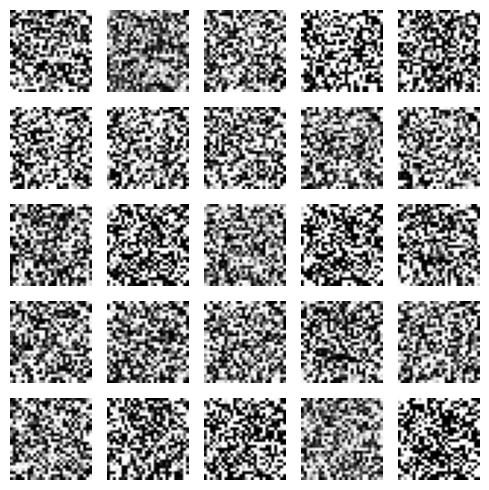

In [69]:
generate_images(generator)